# MemorySavor 사용 예시

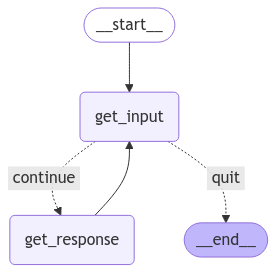

{'messages': [{'role': 'user', 'content': 'Hello'}, {'role': 'user', 'content': 'hello'}, {'role': 'assistant', 'content': 'Hello! How can I assist you today?'}, {'role': 'user', 'content': 'how are you?'}, {'role': 'assistant', 'content': "I'm just a program, but I'm here and ready to help! How can I assist you today?"}, {'role': 'user', 'content': 'bye'}, {'role': 'assistant', 'content': 'Goodbye! If you need anything in the future, feel free to reach out. Have a great day!'}, {'role': 'user', 'content': 'q'}], 'context': '', 'usage': {'input': 60, 'output': 54}}


In [3]:
from dotenv import load_dotenv
from typing import TypedDict
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    messages: list
    context: str
    usage: dict

load_dotenv()
llm = ChatOpenAI(model="gpt-4o-mini")
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a friendly chatbot assistant.",
        ),
        ("human", "{query}"),
    ]
)
chain = prompt | llm

def user_input():
    query = input("user: ")
    return {"role": "user", "content": query}

def chatbot(query: str):
    result = chain.invoke({"query": query})
    usage = result.usage_metadata
    itokens = usage['input_tokens']
    otokens = usage['output_tokens']
    content = result.content
    return {"content": content, "usage": {"input": itokens, "output": otokens}}

def get_input(state: State):
    query = user_input()
    state["messages"] = [query]
    return state

def get_response(state: State):
    query = state["messages"][0]["content"]
    response = chatbot(query)
    print(response["content"])
    state["messages"].append({"role": "assistant", "content": response["content"]})
    state["usage"]["input"] += response["usage"]["input"]
    state["usage"]["output"] += response["usage"]["output"]
    return state

def check_input(state: State):
    query = state["messages"][0]["content"]
    if query == 'q':
        return "quit"
    else:
        return "continue"

memory = MemorySaver() # 대용량 데이터 처리시 메모리 사용량 관리에 주의가 필요함 / 휘발성 -> 중요 데이터는 별도로 백업해야함
workflow = StateGraph(State)
workflow.add_node("get_input", get_input)
workflow.add_node("get_response", get_response)

workflow.add_edge(START, "get_input")
workflow.add_edge("get_response", "get_input")

workflow.add_conditional_edges(
    "get_input",
    check_input,
    {
        "continue" : "get_response",
        "quit": END
    }
)

graph = workflow.compile(checkpointer=memory)

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

config = {"configurable": {"thread_id": "user_123"}}
input_data = {
    "messages": [],
    # [{
    #     "role": "user",
    #     "content": "Hello"
    # }],
    "context": "",
    "usage": {
        "input": 0,
        "output": 0
    }
}
result = graph.invoke(input_data, config=config)

state = graph.get_state(config)
print(state.values)

In [4]:
history = list(graph.get_state_history(config))
for checkpoint in history:
    print(f"Checkpoint ID: {checkpoint.config['configurable']['checkpoint_id']}")
    print(f"State: {checkpoint.values}")

Checkpoint ID: 1efd3ab0-2d35-69e4-8007-9a041499b37e
State: {'messages': [{'role': 'user', 'content': 'Hello'}, {'role': 'user', 'content': 'hello'}, {'role': 'assistant', 'content': 'Hello! How can I assist you today?'}, {'role': 'user', 'content': 'how are you?'}, {'role': 'assistant', 'content': "I'm just a program, but I'm here and ready to help! How can I assist you today?"}, {'role': 'user', 'content': 'bye'}, {'role': 'assistant', 'content': 'Goodbye! If you need anything in the future, feel free to reach out. Have a great day!'}, {'role': 'user', 'content': 'q'}], 'context': '', 'usage': {'input': 60, 'output': 54}}
Checkpoint ID: 1efd3ab0-1e3f-6dd3-8006-7046e27c4921
State: {'messages': [{'role': 'user', 'content': 'Hello'}, {'role': 'user', 'content': 'hello'}, {'role': 'assistant', 'content': 'Hello! How can I assist you today?'}, {'role': 'user', 'content': 'how are you?'}, {'role': 'assistant', 'content': "I'm just a program, but I'm here and ready to help! How can I assist 